# Building the Machine Learning Models

During EDA we found out that, with regards to statistical measures in this exercise (PTS, STL, AST, BLK etc), NBA centers from the US and EU are essentially the same. Put another way, the statistical measures for (which we will build our predictive models) are independant of the 'US or EU' column. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
plt.rcParams["figure.figsize"] = [18,10]

with open("C:/Users/Lukas Buteliauskas/Desktop/Springboard Projects/Capstone Project 1 - NBA Analytics/"
          "3. Exploratory Data Analysis/Player Data Filtered.csv", "r") as player_data_file:
    player_data_df=pd.read_csv(player_data_file)
    
player_data_df_undrafted=player_data_df[player_data_df["Draft Placing"].isnull()] #undrafted player data
player_data_df=player_data_df[player_data_df["Draft Placing"].isnull()==False] # drafted player data

Given that undrafted players make up a sizeable amount of data, and are themselves a specific group of players, their data cannot be disregarded, but at the same time the Draft Rank cannot be reverse engineered. Hence, it makes sense to consider both groups as distinct, and attempt to build models for both seperately.

### Defining the Classifier Performance Printing/Testing Functions

In [2]:
def performance_prints(clf, X_train, X_test, y_train, y_test, cv=5, n_test_print=20): # some performance/test prints
    print("Training performance (R^2): %.3f" % clf.score(X_train, y_train))
    print("Testing performance (R^2): %.3f" % clf.score(X_test, y_test))
    scores=cross_val_score(clf, X_train, y_train, cv=cv)
    print("R^2 cross val mean: %.3f" % (scores.mean()))
    print("95%% confidence interval for R^2: (%.3f, %.3f)" % (scores.mean()-scores.std()*2, scores.mean()+scores.std()*2))
    print("Mean Squared Error (MSE): %.3f\n\nSome test prints:" % mean_squared_error(y_test, y_pred))

    for idx, data in enumerate(zip(y_test, y_pred)): 
        if idx<n_test_print:
            print("Actual: %.2f\t  Predicted: %.2f\tDifference (absolute): %.3f" % (data[0], data[1], np.abs(data[0]-data[1])))
            
def my_resid_plot(y_test, y_pred, label_name=""): # for showing us the residual plots
    residuals=y_test-y_pred
    plt.scatter(y_pred, residuals, color="black")
    plt.title("Residual Plot")
    plt.xlabel("Predicted " + label_name + " Values")
    plt.ylabel("Residuals")
    plt.axhline(y=0, linewidth=3, color="black")
    plt.show()
    
def prediction_plot(y_test, y_pred, label_name=""): # for showing actual values vs predicted values
    plt.scatter(y_test, y_pred, color="black")
    plt.title("Actual vs Predicted " + label_name + " Plot")
    plt.xlabel("Actual " + label_name + " Values")
    plt.ylabel("Predicted " + label_name + " Values")
    plt.show()

## Points per Game (PTS column) Model

Training performance (R^2): 0.816
Testing performance (R^2): 0.807
R^2 cross val mean: 0.815
95% confidence interval for R^2: (0.787, 0.843)
Mean Squared Error (MSE): 6.269

Some test prints:
Actual: 2.20	  Predicted: 2.06	Difference (absolute): 0.138
Actual: 10.20	  Predicted: 11.53	Difference (absolute): 1.333
Actual: 3.20	  Predicted: 4.35	Difference (absolute): 1.153
Actual: 16.50	  Predicted: 12.78	Difference (absolute): 3.720
Actual: 2.30	  Predicted: 2.75	Difference (absolute): 0.451
Actual: 3.80	  Predicted: 6.54	Difference (absolute): 2.742
Actual: 6.40	  Predicted: 13.80	Difference (absolute): 7.401
Actual: 7.90	  Predicted: 9.62	Difference (absolute): 1.724
Actual: 10.60	  Predicted: 11.69	Difference (absolute): 1.094
Actual: 17.00	  Predicted: 16.88	Difference (absolute): 0.116
Actual: 1.00	  Predicted: -0.15	Difference (absolute): 1.145
Actual: 6.40	  Predicted: 6.61	Difference (absolute): 0.206
Actual: 1.60	  Predicted: 2.84	Difference (absolute): 1.243
Actual: 2.40	  Pre

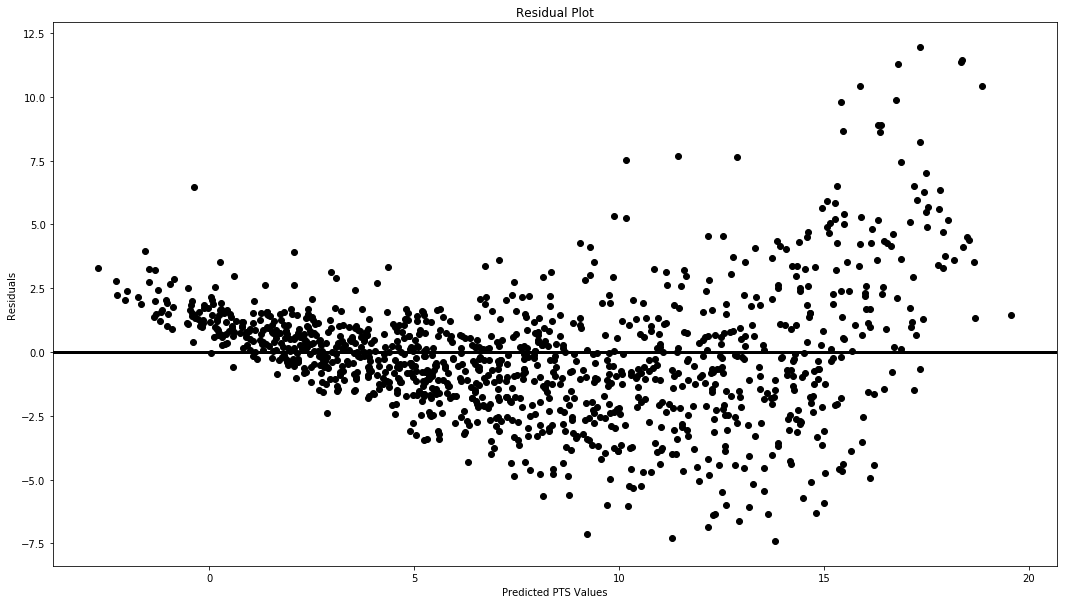

In [3]:
X_eda=player_data_df[["Draft Placing", "eFG%", "Age", "MP"]] # creating a dataframe of only the features selected from EDA.
y=player_data_df["PTS"] # the value we are trying to predict (dependant variable)
X_train, X_test, y_train, y_test=train_test_split(X_eda, y, test_size=0.3, random_state=42) #splitting into train and test sets

clf_pts=LinearRegression().fit(X_train, y_train) # training the model
y_pred=clf_pts.predict(X_test) # getting test sample regression estimates

performance_prints(clf_pts, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="PTS")
#prediction_plot(y_test, y_pred, label_name="PTS")

Though the R^2 is quite high, the residual plot shows us that our model is biased. That is, the values of the errors in our predicitions (residuals) are not independant of the predicted values. Furthermore there is distinct increase in the spread of the residuals as well as a U-shape. All of the prior mean that perhaps we need to transform our data to achieve a model that fits the data better. The next logical step would be include polynomial transformations of the existing features. Given the scatter plots of the independant variables against PTS, we saw at most 1 point of inflection, this means we only need to consider 2nd order polynomials. Another consideration is the curse of dimentionality that would arise if we considered 3rd order polynomial features. Let us try this approach and see if our model performs better.

Training performance (R^2): 0.861
Testing performance (R^2): 0.862
R^2 cross val mean: 0.859
95% confidence interval for R^2: (0.839, 0.879)
Mean Squared Error (MSE): 4.496

Some test prints:
Actual: 2.20	  Predicted: 2.88	Difference (absolute): 0.681
Actual: 10.20	  Predicted: 11.05	Difference (absolute): 0.854
Actual: 3.20	  Predicted: 3.83	Difference (absolute): 0.632
Actual: 16.50	  Predicted: 12.73	Difference (absolute): 3.771
Actual: 2.30	  Predicted: 2.82	Difference (absolute): 0.522
Actual: 3.80	  Predicted: 5.05	Difference (absolute): 1.252
Actual: 6.40	  Predicted: 13.39	Difference (absolute): 6.989
Actual: 7.90	  Predicted: 8.41	Difference (absolute): 0.509
Actual: 10.60	  Predicted: 11.17	Difference (absolute): 0.569
Actual: 17.00	  Predicted: 19.70	Difference (absolute): 2.697
Actual: 1.00	  Predicted: 1.93	Difference (absolute): 0.931
Actual: 6.40	  Predicted: 5.52	Difference (absolute): 0.880
Actual: 1.60	  Predicted: 2.60	Difference (absolute): 0.998
Actual: 2.40	  Pred

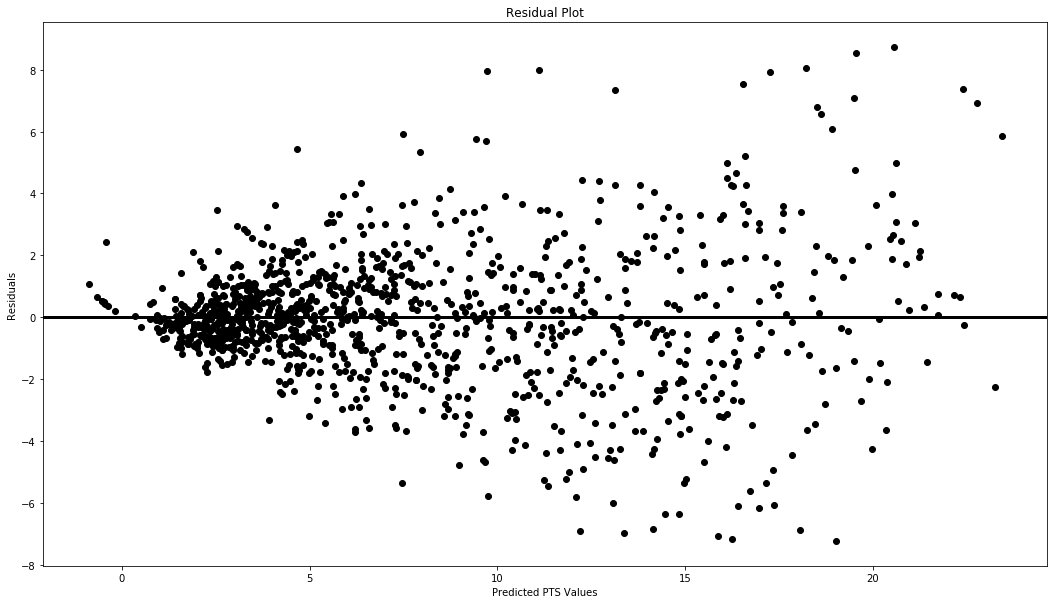

In [4]:
X=PolynomialFeatures(degree=2).fit_transform(X_eda)
y=player_data_df["PTS"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
clf_pts=LinearRegression().fit(X_train, y_train)
y_pred=clf_pts.predict(X_test)

performance_prints(clf_pts, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="PTS")
#prediction_plot(y_test, y_pred, label_name="PTS")

By introducing polynomial features we have succeeded in reducing bias (as demonstrated by a more random residual plot) and also reduced the MSE by ~28% from 6.27 to 4.49. Also, having computed 5-fold cross validation we can be confident in our model's ability to generalise to unseen data. We could either try to tune this model further or choose a different model altogether. Let us try and predict other statistics (AST, TRB, BLK, STL) before attempting to perfect this model.

Training performance (R^2): 0.898
Testing performance (R^2): 0.895
R^2 cross val mean: 0.896
95% confidence interval for R^2: (0.888, 0.903)
Mean Squared Error (MSE): 3.412

Some test prints:
Actual: 2.20	  Predicted: 2.91	Difference (absolute): 0.705
Actual: 10.20	  Predicted: 9.23	Difference (absolute): 0.970
Actual: 3.20	  Predicted: 3.64	Difference (absolute): 0.439
Actual: 16.50	  Predicted: 13.63	Difference (absolute): 2.873
Actual: 2.30	  Predicted: 2.59	Difference (absolute): 0.293
Actual: 3.80	  Predicted: 5.18	Difference (absolute): 1.378
Actual: 6.40	  Predicted: 10.19	Difference (absolute): 3.792
Actual: 7.90	  Predicted: 7.91	Difference (absolute): 0.009
Actual: 10.60	  Predicted: 11.52	Difference (absolute): 0.924
Actual: 17.00	  Predicted: 20.27	Difference (absolute): 3.272
Actual: 1.00	  Predicted: 1.36	Difference (absolute): 0.356
Actual: 6.40	  Predicted: 5.16	Difference (absolute): 1.244
Actual: 1.60	  Predicted: 2.36	Difference (absolute): 0.762
Actual: 2.40	  Predi

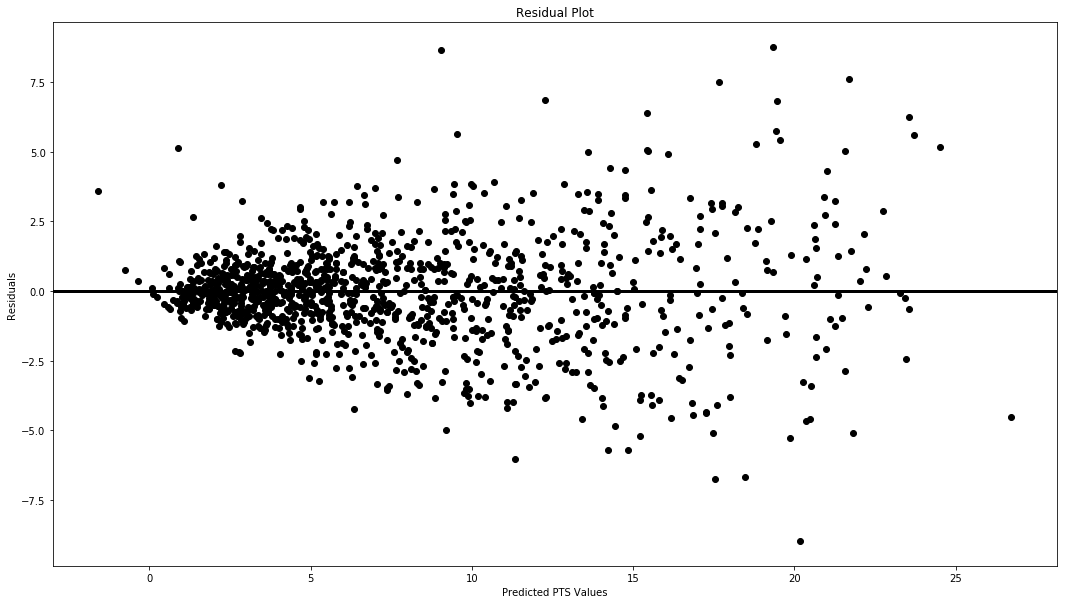

In [5]:
X=PolynomialFeatures(degree=2).fit_transform(player_data_df.iloc[:,[2,3,4,5,6,9,10,11,13]])
y=player_data_df["PTS"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
feats=SFS(LinearRegression(), k_features=15, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).fit(X_train, y_train)

X_train, X_test, y_train, y_test=train_test_split(X[:,feats.k_feature_idx_], y, test_size=0.3, random_state=42)
clf_pts=LinearRegression().fit(X_train, y_train)
y_pred=clf_pts.predict(X_test)

performance_prints(clf_pts, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="PTS")
#prediction_plot(y_test, y_pred, label_name="PTS")

Training performance (R^2): 0.906
Testing performance (R^2): 0.900
R^2 cross val mean: 0.899
95% confidence interval for R^2: (0.894, 0.905)
Mean Squared Error (MSE): 3.249

Some test prints:
Actual: 2.20	  Predicted: 3.14	Difference (absolute): 0.941
Actual: 10.20	  Predicted: 9.25	Difference (absolute): 0.953
Actual: 3.20	  Predicted: 3.74	Difference (absolute): 0.543
Actual: 16.50	  Predicted: 13.82	Difference (absolute): 2.684
Actual: 2.30	  Predicted: 2.91	Difference (absolute): 0.605
Actual: 3.80	  Predicted: 4.93	Difference (absolute): 1.128
Actual: 6.40	  Predicted: 10.69	Difference (absolute): 4.288
Actual: 7.90	  Predicted: 7.92	Difference (absolute): 0.020
Actual: 10.60	  Predicted: 11.89	Difference (absolute): 1.293
Actual: 17.00	  Predicted: 19.87	Difference (absolute): 2.871
Actual: 1.00	  Predicted: 1.42	Difference (absolute): 0.424
Actual: 6.40	  Predicted: 4.99	Difference (absolute): 1.411
Actual: 1.60	  Predicted: 1.85	Difference (absolute): 0.250
Actual: 2.40	  Predi

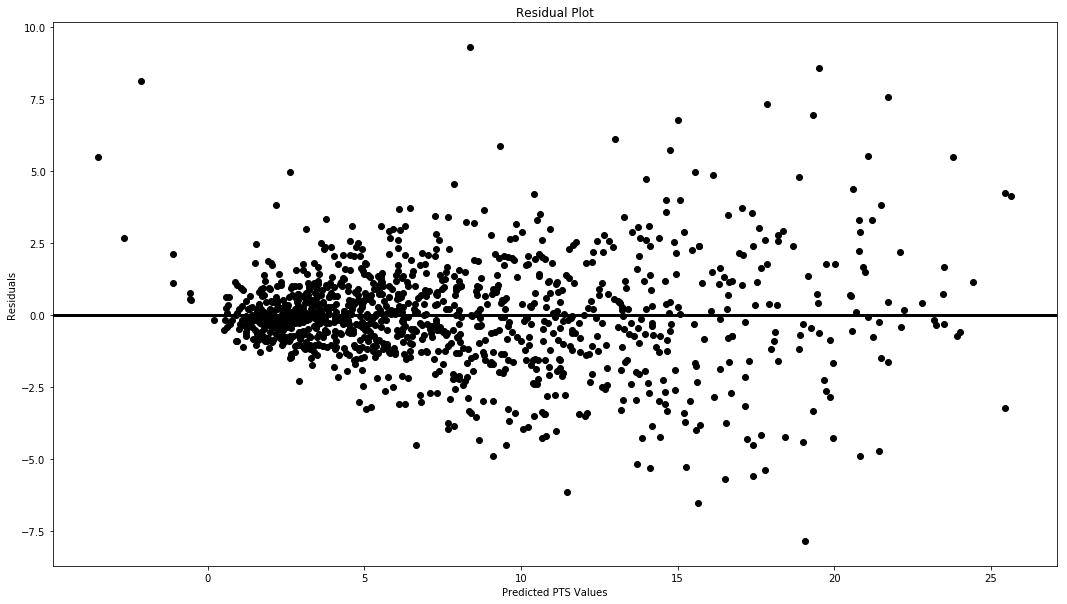

In [6]:
poly_feat=PolynomialFeatures(degree=2).fit(player_data_df.iloc[:,[2,3,4,5,6,9,10,11,13]])
X=poly_feat.transform(player_data_df.iloc[:,[2,3,4,5,6,9,10,11,13]])
y=player_data_df["PTS"]

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
feat_selector=RFECV(LinearRegression(), cv=5).fit(X_train, y_train)
#for name, rank in zip(poly_feat.get_feature_names(player_data_df.iloc[:,[2,3,4,5,6,9,10,11,13]].columns), feat_selector.ranking_):
   #print(name, rank)
X_train, X_test, y_train, y_test=train_test_split(X[:,feat_selector.support_], y, test_size=0.3, random_state=42)
clf_pts=LinearRegression().fit(X_train, y_train)
y_pred=clf_pts.predict(X_test)

performance_prints(clf_pts, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="PTS")
#prediction_plot(y_test, y_pred, label_name="PTS")

## Assists per Game (AST column) Model

Training performance (R^2): 0.623
Testing performance (R^2): 0.591
R^2 cross val mean: 0.619
95% confidence interval for R^2: (0.562, 0.677)
Mean Squared Error (MSE): 0.353

Some test prints:
Actual: 0.30	  Predicted: 0.42	Difference (absolute): 0.125
Actual: 0.80	  Predicted: 1.35	Difference (absolute): 0.549
Actual: 0.30	  Predicted: 0.49	Difference (absolute): 0.187
Actual: 3.40	  Predicted: 1.65	Difference (absolute): 1.745
Actual: 0.30	  Predicted: 0.47	Difference (absolute): 0.166
Actual: 0.90	  Predicted: 0.75	Difference (absolute): 0.149
Actual: 1.30	  Predicted: 2.01	Difference (absolute): 0.714
Actual: 0.70	  Predicted: 1.05	Difference (absolute): 0.351
Actual: 0.70	  Predicted: 1.80	Difference (absolute): 1.103
Actual: 1.50	  Predicted: 2.18	Difference (absolute): 0.678
Actual: 0.10	  Predicted: 0.22	Difference (absolute): 0.123
Actual: 0.20	  Predicted: 0.56	Difference (absolute): 0.355
Actual: 0.20	  Predicted: 0.39	Difference (absolute): 0.193
Actual: 0.40	  Predicted: 0.

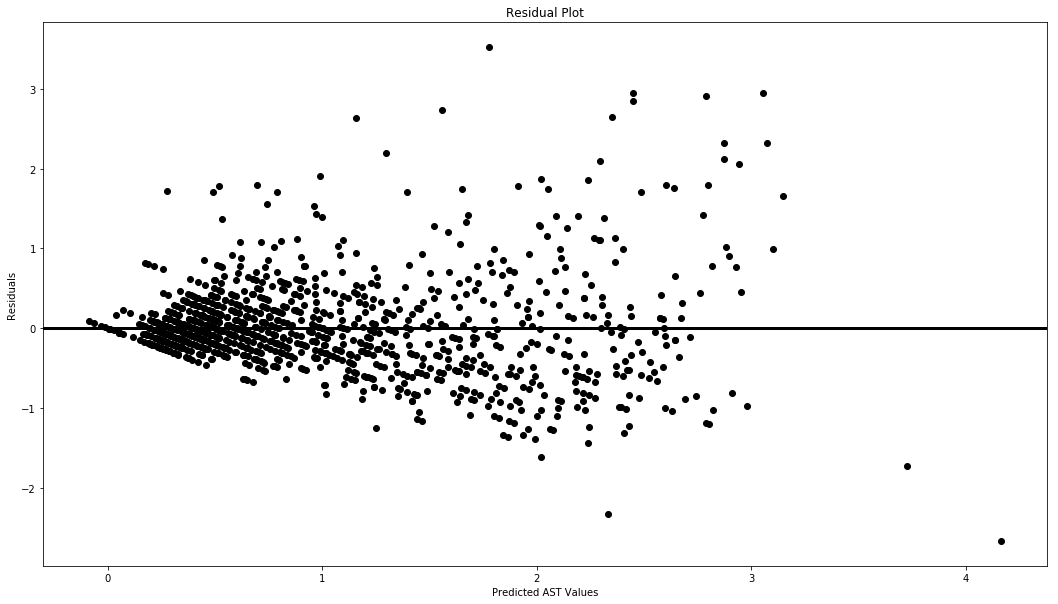

In [7]:
X=PolynomialFeatures(degree=2).fit_transform(X_eda)
y=player_data_df["AST"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

clf_ast=LinearRegression().fit(X_train, y_train)
y_pred=clf_ast.predict(X_test)

performance_prints(clf_ast, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="AST")
#prediction_plot(y_test, y_pred, label_name="AST")

Training performance (R^2): 0.704
Testing performance (R^2): 0.686
R^2 cross val mean: 0.700
95% confidence interval for R^2: (0.667, 0.733)
Mean Squared Error (MSE): 0.271

Some test prints:
Actual: 0.30	  Predicted: 0.42	Difference (absolute): 0.125
Actual: 0.80	  Predicted: 0.92	Difference (absolute): 0.118
Actual: 0.30	  Predicted: 0.54	Difference (absolute): 0.242
Actual: 3.40	  Predicted: 2.39	Difference (absolute): 1.009
Actual: 0.30	  Predicted: 0.29	Difference (absolute): 0.009
Actual: 0.90	  Predicted: 0.95	Difference (absolute): 0.053
Actual: 1.30	  Predicted: 1.32	Difference (absolute): 0.018
Actual: 0.70	  Predicted: 1.23	Difference (absolute): 0.530
Actual: 0.70	  Predicted: 1.55	Difference (absolute): 0.853
Actual: 1.50	  Predicted: 2.33	Difference (absolute): 0.835
Actual: 0.10	  Predicted: 0.00	Difference (absolute): 0.100
Actual: 0.20	  Predicted: 0.51	Difference (absolute): 0.310
Actual: 0.20	  Predicted: 0.37	Difference (absolute): 0.169
Actual: 0.40	  Predicted: 0.

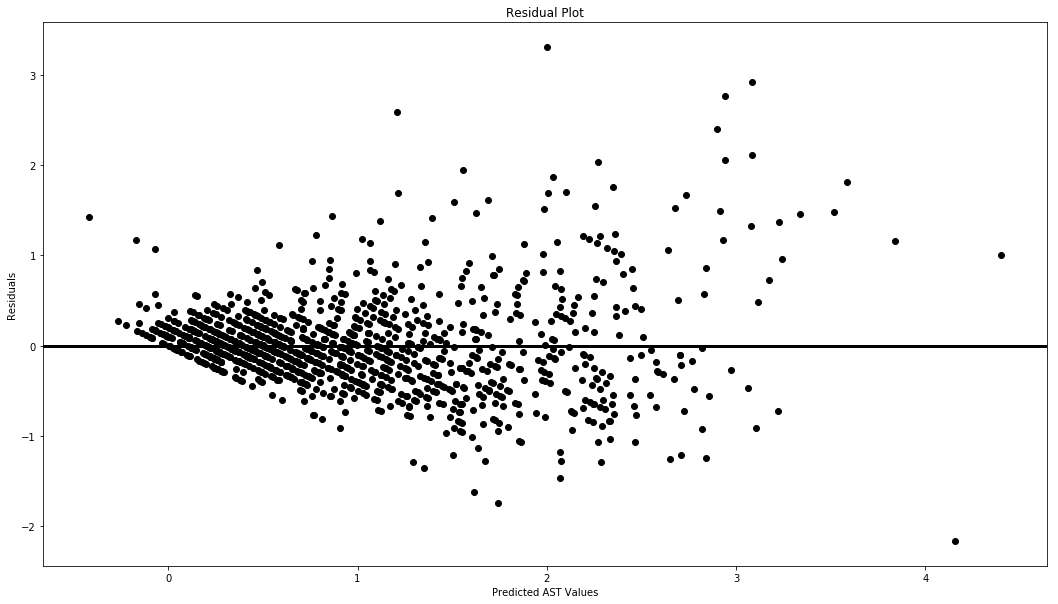

In [8]:
X=player_data_df.iloc[:,[0,1,3,4,5,6,7,8,9,10,11,13]]
y=player_data_df.AST
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

feat_selector=RFECV(LinearRegression(), cv=5).fit(X_train, y_train)
X_train, X_test, y_train, y_test=train_test_split(X.iloc[:,feat_selector.support_], y, test_size=0.3, random_state=42)

clf_ast=LinearRegression().fit(X_train, y_train)
y_pred=clf_ast.predict(X_test)

performance_prints(clf_ast, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="AST")
#prediction_plot(y_test, y_pred, label_name="AST")

**INSERT ASSIST COMMENTS HERE**


## Total Rebounds per Game (TRB column) Model

Training performance (R^2): 0.880
Testing performance (R^2): 0.862
R^2 cross val mean: 0.865
95% confidence interval for R^2: (0.841, 0.889)
Mean Squared Error (MSE): 1.221

Some test prints:
Actual: 2.40	  Predicted: 2.34	Difference (absolute): 0.055
Actual: 7.80	  Predicted: 6.90	Difference (absolute): 0.905
Actual: 3.50	  Predicted: 3.19	Difference (absolute): 0.311
Actual: 9.20	  Predicted: 7.10	Difference (absolute): 2.096
Actual: 4.40	  Predicted: 2.89	Difference (absolute): 1.506
Actual: 3.60	  Predicted: 3.87	Difference (absolute): 0.272
Actual: 6.10	  Predicted: 8.81	Difference (absolute): 2.711
Actual: 5.40	  Predicted: 6.60	Difference (absolute): 1.198
Actual: 8.50	  Predicted: 7.31	Difference (absolute): 1.190
Actual: 12.50	  Predicted: 11.96	Difference (absolute): 0.539
Actual: 0.90	  Predicted: 0.95	Difference (absolute): 0.055
Actual: 4.10	  Predicted: 4.16	Difference (absolute): 0.058
Actual: 1.90	  Predicted: 2.63	Difference (absolute): 0.728
Actual: 2.50	  Predicted: 

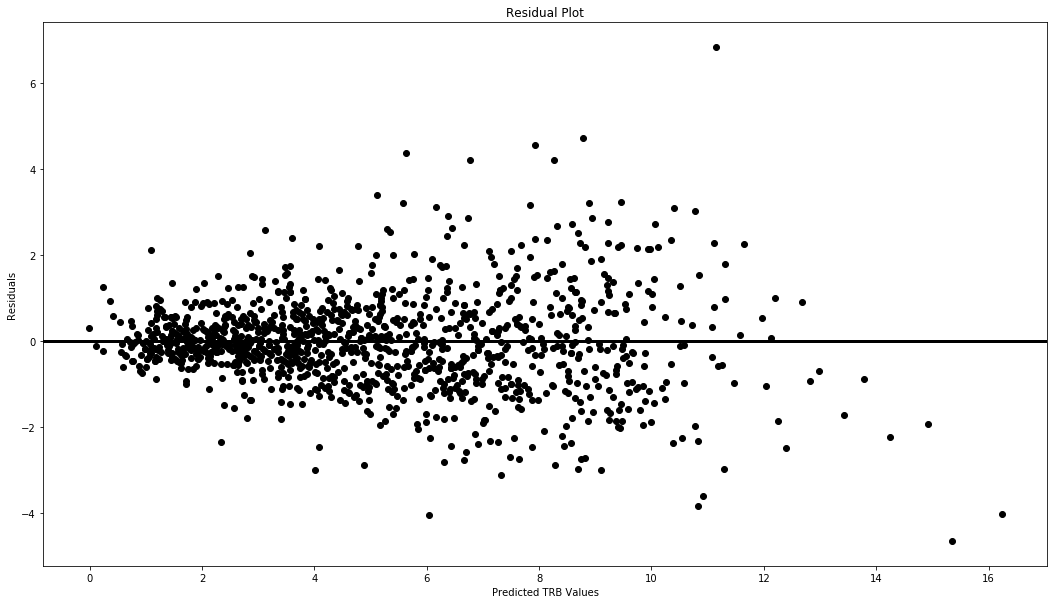

In [9]:
X=PolynomialFeatures(degree=2).fit_transform(player_data_df.iloc[:,[0,1,2,3,4,5,6,8,9,10,13]])
y=player_data_df["TRB"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

clf_trb=LinearRegression().fit(X_train, y_train)
y_pred=clf_trb.predict(X_test)

performance_prints(clf_trb, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="TRB")
#prediction_plot(y_test, y_pred, label_name="TRB")

Like in the PTS model case, the residuals are roughly randomly distributed, however for higher predicted values we see a larger variance in the residuals.

## Blocks per Game (BLK column) Model

Training performance (R^2): 0.519
Testing performance (R^2): 0.456
R^2 cross val mean: 0.471
95% confidence interval for R^2: (0.386, 0.557)
Mean Squared Error (MSE): 0.280

Some test prints:
Actual: 0.20	  Predicted: 0.39	Difference (absolute): 0.190
Actual: 2.00	  Predicted: 1.27	Difference (absolute): 0.726
Actual: 0.50	  Predicted: 0.61	Difference (absolute): 0.113
Actual: 1.10	  Predicted: 1.10	Difference (absolute): 0.002
Actual: 0.70	  Predicted: 0.58	Difference (absolute): 0.124
Actual: 0.20	  Predicted: 0.58	Difference (absolute): 0.384
Actual: 0.90	  Predicted: 1.31	Difference (absolute): 0.409
Actual: 0.60	  Predicted: 0.93	Difference (absolute): 0.329
Actual: 0.50	  Predicted: 1.41	Difference (absolute): 0.908
Actual: 1.30	  Predicted: 1.90	Difference (absolute): 0.595
Actual: 0.10	  Predicted: 0.14	Difference (absolute): 0.041
Actual: 1.70	  Predicted: 0.83	Difference (absolute): 0.874
Actual: 0.80	  Predicted: 0.32	Difference (absolute): 0.484
Actual: 0.70	  Predicted: 0.

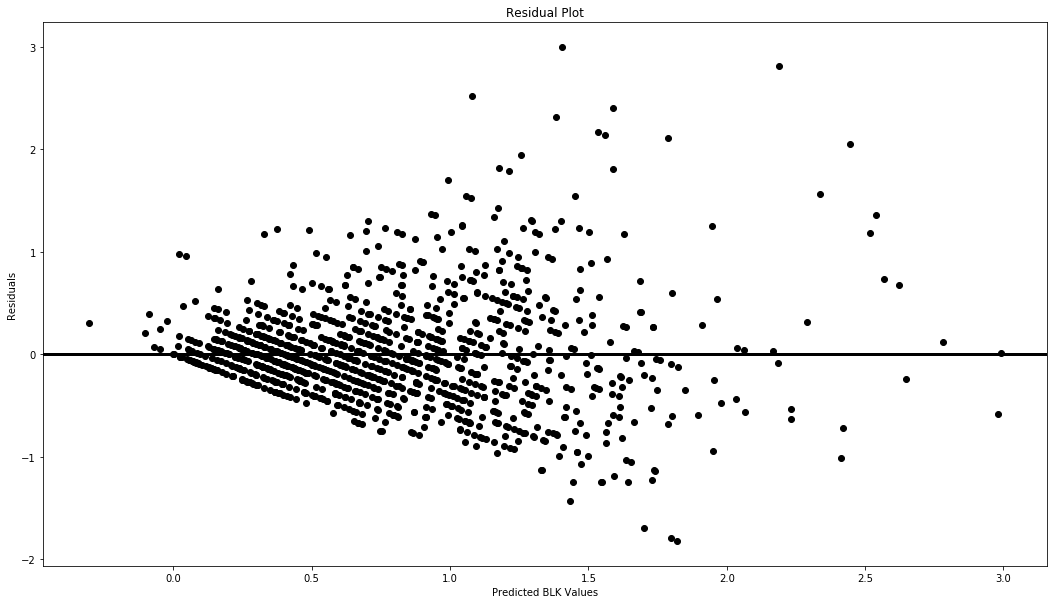

In [10]:
X=PolynomialFeatures(degree=2).fit_transform(player_data_df.iloc[:,[0,1,2,3,5,6,8,9,10,11,13]])
y=player_data_df["BLK"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

clf_blk=LinearRegression().fit(X_train, y_train)
y_pred=clf_blk.predict(X_test)

performance_prints(clf_blk, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="BLK")
#prediction_plot(y_test, y_pred, label_name="BLK")

This is totally horrible, we need to do something different.

## Steals per Game (STL column) Model

Training performance (R^2): 0.665
Testing performance (R^2): 0.562
R^2 cross val mean: 0.618
95% confidence interval for R^2: (0.549, 0.687)
Mean Squared Error (MSE): 0.054

Some test prints:
Actual: 0.40	  Predicted: 0.24	Difference (absolute): 0.164
Actual: 0.70	  Predicted: 0.66	Difference (absolute): 0.040
Actual: 0.30	  Predicted: 0.30	Difference (absolute): 0.004
Actual: 1.00	  Predicted: 0.99	Difference (absolute): 0.013
Actual: 0.10	  Predicted: 0.28	Difference (absolute): 0.185
Actual: 0.50	  Predicted: 0.46	Difference (absolute): 0.037
Actual: 0.90	  Predicted: 0.81	Difference (absolute): 0.088
Actual: 1.10	  Predicted: 0.52	Difference (absolute): 0.585
Actual: 0.40	  Predicted: 0.67	Difference (absolute): 0.271
Actual: 1.10	  Predicted: 0.87	Difference (absolute): 0.233
Actual: 0.00	  Predicted: 0.07	Difference (absolute): 0.069
Actual: 0.30	  Predicted: 0.33	Difference (absolute): 0.028
Actual: 0.40	  Predicted: 0.23	Difference (absolute): 0.166
Actual: 0.20	  Predicted: 0.

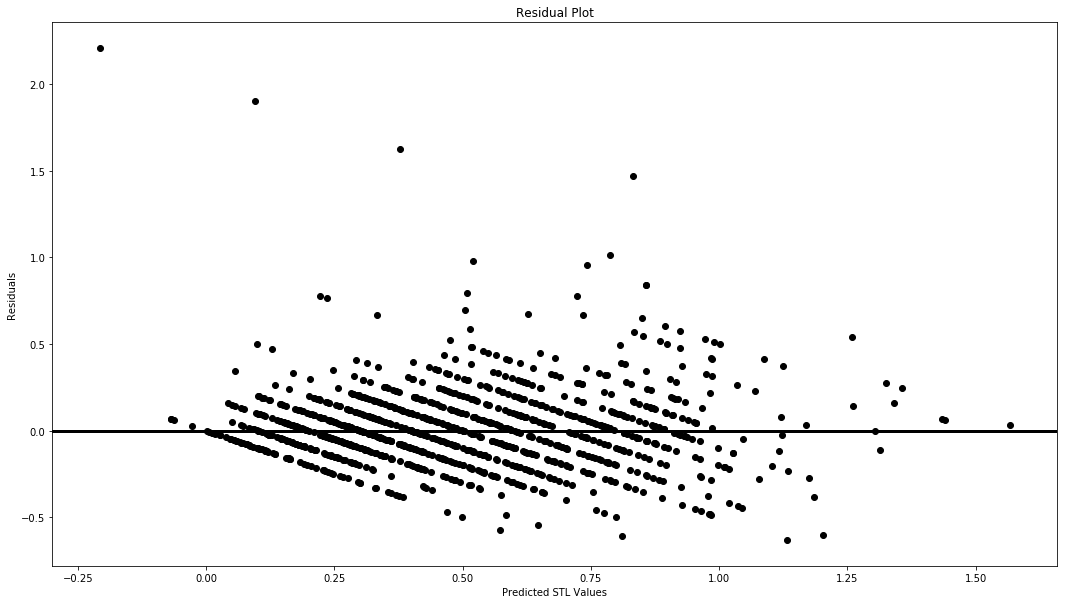

In [11]:
X=PolynomialFeatures(degree=2).fit_transform(player_data_df.iloc[:,[0,1,2,3,4,5,6,8,10,11,13]])
y=player_data_df["STL"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

clf_stl=LinearRegression().fit(X_train, y_train)
y_pred=clf_stl.predict(X_test)

performance_prints(clf_stl, X_train, X_test, y_train, y_test)
my_resid_plot(y_test, y_pred, label_name="STL")
#prediction_plot(y_test, y_pred, label_name="STL")

This also doesn't perform ideally. 